# Loading Libraries

In [1]:
# Pandas, Numpy
import pandas as pd
import numpy as np 

# Tensorflow
import tensorflow as tf 

# RBM from Recommenders
from recommenders.models.rbm.rbm import RBM 
from recommenders.utils.timer import Timer 
from recommenders.utils.plot import line_graph 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k
)
from sklearn.metrics import accuracy_score 

# Visualization
from matplotlib import pyplot as plt 

# Import & Read Dataset

In [2]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/rec_sys_ratings_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/rec_sys_ratings_test.csv", index_col=0)

In [3]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (393208, 3)
Shape of Test: 	 (98401, 3)


In [4]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3011
Unique Users in Test: 3011
Unique Items in Train: 2318
Unique Items in Test: 2318


In [5]:
# Value Counts of Ratings in Train
train.purchased.value_counts()

-1    154381
 1    106450
-2    101061
 2     31316
Name: purchased, dtype: int64

In [6]:
# Value Counts of Ratings in Test
test.purchased.value_counts()

-1    38596
 1    26702
-2    25265
 2     7838
Name: purchased, dtype: int64

# Preparation of Datasets for Modeling 

In [7]:
# Set standard names for the analysis 
header = {
        "col_user": "CustomerID",
        "col_item": "StockCode",
        "col_rating": "purchased",
    }

# Instantiate the sparse matrix generation  
am_train = AffinityMatrix(df = train, col_user='CustomerID', col_item='StockCode', col_rating='purchased')
am_test = AffinityMatrix(df = test, col_user='CustomerID', col_item='StockCode', col_rating='purchased')

# Obtain the sparse matrix 
Xtr, _, _ = am_train.gen_affinity_matrix()
Xtst, _, _ = am_test.gen_affinity_matrix()

In [8]:
# Sanity Check: Print Shape of Train & Test Matrix - Do numbers match nr of unique users and items from above 
print(Xtr.shape)
print(Xtst.shape) 

(3011, 2318)
(3011, 2318)


In [10]:
# Sanity check: Xtr & Xtst After reloading & Transformation
print(np.unique(Xtr))
print(np.unique(Xtst))

[-2 -1  0  1  2]
[-2 -1  0  1  2]


# Modeling

## Hyperparameter Tuning 1 

In [11]:
# Set up Parameters 
hidden_neurons = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
batch = [200, 300]
lrate = [0.002, 0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])), # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2023-05-24 07:49:33.283371: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 07:49:33.328185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Recall at 10 for  500 neurons: 0.008114557769667307
Recall at 10 for  500 neurons: 0.009066127206844854
Recall at 10 for  500 neurons: 0.010192659169705479
Recall at 10 for  500 neurons: 0.006884726897532856
Recall at 10 for  500 neurons: 0.007624979712228796
Recall at 10 for  500 neurons: 0.008180219965364484
Recall at 10 for  600 neurons: 0.012114217917440972
Recall at 10 for  600 neurons: 0.013286064627249728
Recall at 10 for  600 neurons: 0.013912541753820775
Recall at 10 for  600 neurons: 0.010235488709770453
Recall at 10 for  600 neurons: 0.010737621815102757
Recall at 10 for  600 neurons: 0.011601874906627
Recall at 10 for  700 neurons: 0.015333240398445025
Recall at 10 for  700 neurons: 0.016604314553728912
Recall at 10 for  700 neurons: 0.01812347236218525
Recall at 10 for  700 neurons: 0.013442136706283829
Recall at 10 for  700 neurons: 0.014287724658079086
Recall at 10 for  700 neurons: 0.014712630307857612
Recall at 10 for  800 neurons: 0.013705818830686266
Recall at 10 for

In [12]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_1 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_1.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
56,1400,200,0.004,0.040196,0.055319,0.144503,0.100764
62,1500,200,0.004,0.040015,0.056190,0.145433,0.103305
55,1400,200,0.003,0.037616,0.052908,0.136134,0.096745
61,1500,200,0.003,0.037613,0.054619,0.136267,0.099568
50,1300,200,0.004,0.036857,0.052298,0.134075,0.096314
...,...,...,...,...,...,...,...
1,500,200,0.003,0.009066,0.015361,0.033975,0.028944
5,500,300,0.004,0.008180,0.013887,0.030687,0.025971
0,500,200,0.002,0.008115,0.014141,0.030488,0.026470
4,500,300,0.003,0.007625,0.013341,0.028728,0.025158


## Hyperparameter Tuning 2

In [14]:
# Set up Parameters 
hidden_neurons = [1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490]
batch = [200, 300]
lrate = [0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])), # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Recall at 10 for  1310 neurons: 0.034191814745106415
Recall at 10 for  1310 neurons: 0.035785837202115846
Recall at 10 for  1310 neurons: 0.028124948298543333
Recall at 10 for  1310 neurons: 0.031086151510048694
Recall at 10 for  1320 neurons: 0.033853317278515226
Recall at 10 for  1320 neurons: 0.03525330827260912
Recall at 10 for  1320 neurons: 0.027119141443262204
Recall at 10 for  1320 neurons: 0.029944164435475776
Recall at 10 for  1330 neurons: 0.03489597073245282
Recall at 10 for  1330 neurons: 0.037066870599850844
Recall at 10 for  1330 neurons: 0.027328171145526263
Recall at 10 for  1330 neurons: 0.03077424262073007
Recall at 10 for  1340 neurons: 0.03216223078656515
Recall at 10 for  1340 neurons: 0.0352923231648199
Recall at 10 for  1340 neurons: 0.02564725045007901
Recall at 10 for  1340 neurons: 0.028919281343868806
Recall at 10 for  1350 neurons: 0.033817711175820366
Recall at 10 for  1350 neurons: 0.037533420466283114
Recall at 10 for  1350 neurons: 0.027120752427410442


In [15]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
57,1450,200,0.004,0.045920,0.063352,0.165095,0.115061
49,1430,200,0.004,0.043390,0.060247,0.155297,0.109200
69,1480,200,0.004,0.043379,0.059768,0.156559,0.109532
56,1450,200,0.003,0.043239,0.060694,0.155895,0.110993
61,1460,200,0.004,0.042547,0.059365,0.154268,0.108967
...,...,...,...,...,...,...,...
18,1350,300,0.003,0.027121,0.040492,0.099136,0.074776
6,1320,300,0.003,0.027119,0.041064,0.099469,0.075390
22,1360,300,0.003,0.026444,0.039840,0.097011,0.073364
26,1370,300,0.003,0.026159,0.039545,0.096015,0.073215


# Final Tuning Round

In [16]:
# Set up Parameters 
hidden_neurons = [1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459]
batch = [200, 300]
lrate = [0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])), # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Recall at 10 for  1441 neurons: 0.040883290150488506
Recall at 10 for  1441 neurons: 0.042334860971920095
Recall at 10 for  1441 neurons: 0.033137887903425596
Recall at 10 for  1441 neurons: 0.037250217267710314
Recall at 10 for  1442 neurons: 0.038912980364673
Recall at 10 for  1442 neurons: 0.04253615121656063
Recall at 10 for  1442 neurons: 0.030223030773589753
Recall at 10 for  1442 neurons: 0.0330757191594935
Recall at 10 for  1443 neurons: 0.04428575286262496
Recall at 10 for  1443 neurons: 0.04487608750425936
Recall at 10 for  1443 neurons: 0.034899370817135685
Recall at 10 for  1443 neurons: 0.038725051201334765
Recall at 10 for  1444 neurons: 0.03996096045111019
Recall at 10 for  1444 neurons: 0.042836556134196006
Recall at 10 for  1444 neurons: 0.03250525097706066
Recall at 10 for  1444 neurons: 0.03588878041143937
Recall at 10 for  1445 neurons: 0.04160021950098012
Recall at 10 for  1445 neurons: 0.044246985905058496
Recall at 10 for  1445 neurons: 0.03381451130468951
Recall

In [17]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_3 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_3.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
37,1450,200,0.004,0.045647,0.063683,0.164929,0.116058
9,1443,200,0.004,0.044876,0.061643,0.162172,0.112936
53,1454,200,0.004,0.044652,0.062053,0.161142,0.113235
69,1458,200,0.004,0.044519,0.061869,0.159714,0.112454
36,1450,200,0.003,0.044398,0.060928,0.159083,0.111010
...,...,...,...,...,...,...,...
66,1457,300,0.003,0.031402,0.046228,0.113982,0.084939
74,1459,300,0.003,0.030893,0.045050,0.112288,0.082962
26,1447,300,0.003,0.030706,0.046394,0.112122,0.085437
6,1442,300,0.003,0.030223,0.045496,0.110794,0.083793


In [24]:
df_tuning_3.groupby('minibatches')['recall@10'].mean()

minibatches
200    0.041904
300    0.034375
Name: recall@10, dtype: float64

In [25]:
df_tuning_3.groupby('learning_rates')['recall@10'].mean()

learning_rates
0.003    0.036806
0.004    0.039473
Name: recall@10, dtype: float64

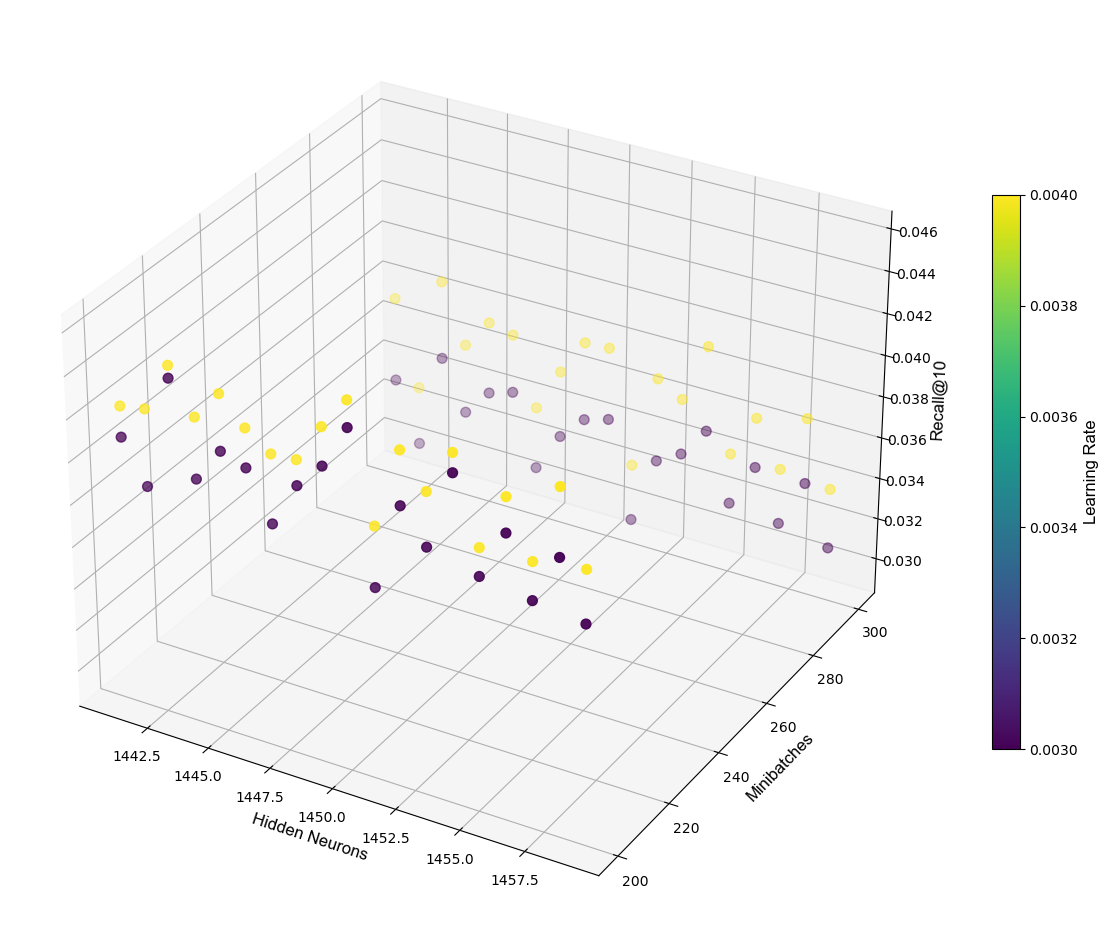

In [18]:
fig = plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x, y, z = df_tuning_3.hidden_neurons, df_tuning_3['minibatches'], df_tuning_3['recall@10']
ax.set_xlabel('Hidden Neurons', fontname='Arial', fontsize=12)
ax.set_ylabel('Minibatches',fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10',fontname='Arial', fontsize=12)
scatter = ax.scatter(x,y,z, cmap='viridis', marker='o', s=50, c=df_tuning_3['learning_rates'])

# Colorbar
cbar = plt.colorbar(scatter, shrink=0.6)
cbar.set_label('Learning Rate', fontname='Arial', fontsize=12)
plt.show()


# Best Model: Accuracy on Test

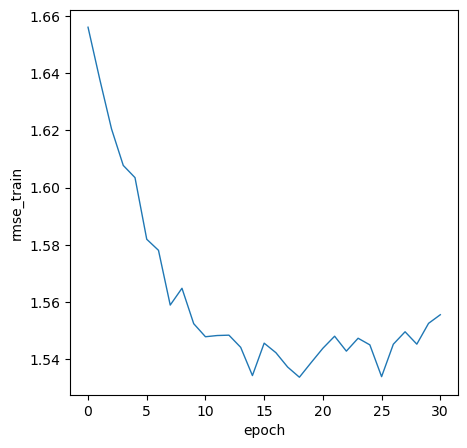

In [19]:
# Set up Model Object
best_model = RBM(possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])), # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=1450,
                training_epoch=30,
                minibatch_size=200,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=0.004,
                seed=42)
            
# Fit Model 
best_model.fit(Xtr)

# Line Graph
line_graph(values=best_model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')


In [20]:
# Make Predictions for entire Test Matrix
pred_test = best_model.predict(Xtst) ## Always Use Xtst for prediction - better results 

# Map Back Pred Test
pred_test = am_test.map_back_sparse(pred_test, kind = 'prediction')

# Merge test_pred with test
test_prediction_am = test_df.merge(pred_test, on=['StockCode', 'CustomerID'], how='left')

# Change Purchased above 0 to 1 and below zero to 0 
test_prediction_am['purchased'] = test_prediction_am['purchased'].apply(lambda x: 0 if x < 0 else 1 )

# Change prediction above 0 to 1 and below zero to 0 
test_prediction_am['prediction'] = test_prediction_am['prediction'].apply(lambda x: 0 if x < 0 else 1 )

# Accuracy 
accuracy_score(test_prediction_am.purchased, test_prediction_am.prediction)

0.9215861627422486